# Industry-grade, hands-on RL with Ray RLlib
## Recommender systems, offline RL, and policy serving

<table>
<tr>
    <td> <img src="images/youtube.png" style="width: 230px;"/> </td>
    <td> <img src="images/dota2.jpg" style="width: 213px;"/> </td>
    <td> <img src="images/forklifts.jpg" style="width: 169px;"/> </td>
    <td> <img src="images/spotify.jpg" style="width: 254px;"/> </td>
    <td> <img src="images/robots.jpg" style="width: 252px;"/> </td>
</tr>
</table>


### Overview
“Industry-grade, hands-on RL with Ray RLlib” is a tutorial for industry researchers, domain-experts, and ML-engineers, showcasing ...

1) .. how you can use RLlib to build a recommender system simulator for your industry applications and run a slate-capable algorithm against this simulator.

2) .. how RLlib's offline algorithms pose solutions in case you don't have a simulator of your problem environment at hand.

We will further explore how to deploy one or more trained models to production using Ray Serve and how to use RLlib's bandit algorithms to select a best model from some set of candidates for that purpose.

During the live-coding phases, we will build a recommender system simulating environment with RLlib and google's RecSim, choose, configure, and run an RLlib algorithm, and experiment and tune hyperparameters with Ray Tune.

RLlib offers industry-grade scalability, a large list of algos to choose from (offline, model-based, model-free, etc..), support for TensorFlow and PyTorch, and a unified API for a variety of applications. This tutorial includes a brief introduction to provide an overview of concepts (e.g. why RL?) before proceeding to RLlib (recommender system) environments, neural network models, offline RL, student exercises, Q/A, and more. All code will be provided as .py files in a GitHub repo.

### Intended Audience
* Python programmers who are interested in using RL to solve their specific industry decision making problems and who want to get started with RLlib.

### Prerequisites
* Some Python programming experience.
* Some familiarity with machine learning.
* *Helpful, but not required:* Experience in reinforcement learning and Ray.
* *Helpful, but not required:* Experience with TensorFlow or PyTorch.

### Requirements/Dependencies

To get this very notebook up and running on your local machine, you can follow these steps here:

Install conda (https://www.anaconda.com/products/individual)

Then ...

#### Quick `conda` setup instructions (Linux):
```
$ conda create -n rllib_tutorial python=3.9
$ conda activate rllib_tutorial
$ pip install "ray[rllib,serve]" recsim jupyterlab
$ pip install tensorflow  # <- either one works!
$ pip install torch  # <- either one works!
```

#### Quick `conda` setup instructions (Mac):
```
$ conda create -n rllib python=3.9
$ conda activate rllib_tutorial
$ pip install cmake "ray[rllib,serve]" recsim jupyterlab
$ pip install grpcio # <- extra install only on apple M1 mac
$ pip install tensorflow  # <- either one works!
$ pip install torch  # <- either one works!
```

#### Quick `conda` setup instructions (Win10):
```
$ conda create -n rllib python=3.9
$ conda activate rllib_tutorial
$ pip install "ray[rllib,serve]" recsim jupyterlab pywin32
$ pip install tensorflow  # <- either one works!
$ pip install torch  # <- either one works!
```

### Opening these tutorial files:
```
$ git clone https://github.com/sven1977/rllib_tutorials
$ cd rllib_tutorials/rl_conference_2022
$ jupyter-lab
```


### Key Takeaways
* What is reinforcement learning and why RLlib?
* How do recommender systems work? How do we build our own?
* How to configure and hyperparameter-tune an RLlib algorithm that learns how to best recommend items.
* RLlib debugging best practices.


### Tutorial Outline

1. RL and RLlib in a nutshell.
1. Defining an RLlib-ready recommender system emulator with google's RecSim.
1. Picking an algorithm and training our first RLlib Trainer.
1. Configurations and hyperparameters - Easy tuning with Ray Tune.

(15min break)

1. Intro to Offline RL.
1. What if we don't have an environment? Pretending the output of our previous experiments is historic data with which we can train an offline RL agent.
1. BC and MARWIL: Quick how-to and setup instructions.
1. Off policy evaluation (OPE) as a means to estimate how well an offline-RL trained policy will perform in production.

(15min break)

1. Checkpointing and restoring a Trainer.
1. Ray Serve example: How can we deploy a trained policy into our production environment?
1. Quick Ray Serve example.
1. TODO: Bandits for training how to select the best policy in production.


### Other Recommended Readings
* [Reinforcement Learning with RLlib in the Unity Game Engine](https://medium.com/distributed-computing-with-ray/reinforcement-learning-with-rllib-in-the-unity-game-engine-1a98080a7c0d)

<img src="images/unity3d_blog_post.png" width=400>

* [Attention Nets and More with RLlib's Trajectory View API](https://medium.com/distributed-computing-with-ray/attention-nets-and-more-with-rllibs-trajectory-view-api-d326339a6e65)
* [Intro to RLlib: Example Environments](https://medium.com/distributed-computing-with-ray/intro-to-rllib-example-environments-3a113f532c70)

## The RL cycle

<img src="images/rl-cycle.png" width=800>

### Coding/defining our "problem" via an RL environment.

We will use the following recommender system simulating environment (based on google's RecSim package)
throughout this tutorial to demonstrate a large fraction of RLlib's
APIs, features, and customization options.

<img src="images/environment.png" width=800>

#### A word or two on Spaces:

Spaces are used in ML to describe what possible/valid values inputs and outputs of a neural network can have.

RL environments also use them to describe what their valid observations and actions are.

Spaces are usually defined by their shape (e.g. 84x84x3 RGB images) and datatype (e.g. uint8 for RGB values between 0 and 255).
However, spaces could also be composed of other spaces (see Tuple or Dict spaces) or could be simply discrete with n fixed possible values
(represented by integers). For example, in our recommender system env, where our agent has to suggest a k-slate of items, the action space would be `MultiDiscrete([num-items] * k)`. Our observation space will be a more complex `Dict` space containing user, item (document) and response information.

<img src="images/spaces.png" width=800>

# Diving in - Let's start coding!

In [16]:
# Let's get started with some basic imports.

import ray  # .. of course

import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pprint
from scipy.stats import sem  # standard error of the mean
import torch

In [6]:
from typing import List, Optional

from ray.rllib.utils.numpy import softmax


class RecommSys001(gym.Env):

    def __init__(self, config=None):

        config = config or {}

        # E (embedding size)
        self.num_features = config["num_features"]
        # D
        self.num_items_to_select_from = config["num_items_to_select_from"]
        # k
        self.slate_size = config["slate_size"]

        self.num_items_in_db = config.get("num_items_in_db")
        self.items_db = None
        # Generate an items-DB containing n items, once.
        if self.num_items_in_db is not None:
            self.items_db = [np.random.uniform(-1, 1, size=(self.num_features,))
                            for _ in range(self.num_items_in_db)]

        self.num_users_in_db = config.get("num_users_in_db")
        self.users_db = None
        # Store the user that's currently undergoing the episode/session.
        self.current_user = None

        # How much time does the user have to consume 
        self.user_time_budget = config.get("user_time_budget", 1.0)
        self.current_user_budget = self.user_time_budget

        self.observation_space = gym.spaces.Dict({
            # The D items our agent sees at each timestep. It has to select a k-slate
            # out of these.
            "doc": gym.spaces.Dict({
                str(idx):
                    gym.spaces.Box(-1.0, 1.0, shape=(self.num_features,), dtype=np.float32)
                    for idx in range(self.num_items_to_select_from)
            }),
            # The user engaging in this timestep/episode.
            "user": gym.spaces.Box(-1.0, 1.0, shape=(self.num_features,), dtype=np.float32),
            # For each item in the previous slate, was it clicked? If yes, how
            # long was it being engaged with (e.g. watched)?
            "response": gym.spaces.Tuple([
                gym.spaces.Dict({
                    # Clicked or not?
                    "click": gym.spaces.Discrete(2),
                    # Engagement time (how many minutes watched?).
                    "engagement": gym.spaces.Box(-np.inf, np.inf, shape=(), dtype=np.float32),
                }) for _ in range(self.slate_size)
            ]),
        })
        # Our action space is
        self.action_space = gym.spaces.MultiDiscrete([
            self.num_items_to_select_from for _ in range(self.slate_size)
        ])

    def reset(self):
        # Reset the current user's time budget.
        self.current_user_budget = self.user_time_budget

        # Sample a user for the next episode/session.
        # Pick from a only-once-sampled user DB.
        if self.num_users_in_db is not None:
            if self.users_db is None:
                self.users_db = [np.random.uniform(-1, 1, size=(self.num_features,))
                                 for _ in range(self.num_users_in_db)]
            self.current_user = self.users_db[np.random.choice(self.num_users_in_db)]
        # Pick from an infinite pool of users.
        else:
            self.current_user = np.random.uniform(-1, 1, size=(self.num_features,))

        return self._get_obs()

    def step(self, action):
        # Action is the suggested slate (indices of the items in the suggested ones).

        scores = [np.dot(self.current_user, item)
                  for item in self.currently_suggested_items]
        best_reward = np.max(scores)

        # User choice model: User picks an item stochastically,
        # where probs are dot products between user- and item feature
        # vectors.
        # There is also a no-click item whose weight is 0.0.
        user_item_overlaps = np.array([scores[a] for a in action] + [0.0])
        which_clicked = np.random.choice(
            np.arange(self.slate_size + 1), p=softmax(user_item_overlaps))

        # Reward is the overlap, if clicked. 0.0 if nothing clicked.
        reward = 0.0
        # If anything clicked, deduct from the current user's time budget and compute
        # reward.
        if which_clicked < self.slate_size:
            regret = best_reward - user_item_overlaps[which_clicked]
            reward = 1.0 - regret
            self.current_user_budget -= 1.0
        done = self.current_user_budget <= 0.0

        # Compile response.
        response = tuple({
            "click": int(idx == which_clicked),
            "engagement": reward if idx == which_clicked else 0.0,
        } for idx in range(len(user_item_overlaps) - 1))

        # Return 4-tuple: Next-observation, reward, done (True if episode has terminated), info dict (empty; not used here).
        return self._get_obs(response=response), reward, done, {}

    def _get_obs(self, response=None):
        # Sample D items from infinity or our pre-existing items.
        # Pick from a only-once-sampled items DB.
        if self.num_items_in_db is not None:
            self.currently_suggested_items = [
                self.items_db[item_idx].astype(np.float32)
                for item_idx in np.random.choice(self.num_items_in_db,
                                                size=(self.num_items_to_select_from,),
                                                replace=False)
            ]
        # Pick from an infinite pool of itemsdocs.
        else:
            self.currently_suggested_items = [
                np.random.uniform(-1, 1, size=(self.num_features,)).astype(np.float32)
                for _ in range(self.num_items_to_select_from)
            ]

        return {
            "user": self.current_user.astype(np.float32),
            "doc": {
                str(idx): item for idx, item in enumerate(self.currently_suggested_items)
            },
            "response": response if response else self.observation_space["response"].sample()
        }

env = RecommSys001(config={
    "num_features": 20,  # E (embedding size)

    "num_items_in_db": 100,  # total number of items in our database
    "num_items_to_select_from": 10,  # number of items to present to the agent to pick a k-slate from
    "slate_size": 1,  # k
    "num_users_in_db": 1,  # total number  of users in our database
})
env

## Testing our environment

In the cell above, we created a new environment instance. In order to start "walking" through a recommender system episode, we need to perform `reset()` and then several `step()` calls (with different actions) until the returned `done` flag is True.

Let's follow these instructions here to get this done:

1. `reset` the already created (variable `env`) environment to get the first (initial) observation.
1. Enter an infinite while loop.
1. Compute the next action for our agent by calling `env.action_space.sample()`.
1. Pass this computed action into the env's `step()` method.
1. Check the returned `done` for True (episode is terminated) and if True, break out of the loop.



In [76]:
# !LIVE CODING!

def test_env(env):

    # 1) Reset the env.
    obs = env.reset()

    # Number of episodes already done.
    num_episodes = 0
    # Current episode's accumulated reward.
    episode_reward = 0.0
    # Collect all episode rewards here to be able to calculate a random baseline reward.
    episode_rewards = []

    # 2) Enter an infinite while loop (to step through the episode).
    while num_episodes < 1000:
        # 3) Calculate agent's action, using random sampling via the environment's action space.
        action = env.action_space.sample()
        # action = trainer.compute_single_action([obs])

        # 4) Send the action to the env's `step()` method to receive: obs, reward, done, and info.
        obs, reward, done, info = env.step(action)
        episode_reward += reward

        # 5) Check, whether the episde is done, if yes, break out of the while loop.
        if done:
            #print(f"Episode done - accumulated reward={episode_reward}")
            num_episodes += 1
            env.reset()
            episode_rewards.append(episode_reward)
            episode_reward = 0.0

    # 6) Print out mean episode reward!
    env_mean_random_reward = np.mean(episode_rewards)
    print(f"Avg. episode reward={env_mean_random_reward:.2f}+/-{sem(episode_rewards):.2f}")

    return env_mean_random_reward, sem(episode_rewards)

env_mean_random_reward, env_sem_random_reward = test_env(env)


Avg. episode reward=-0.26+/-0.04


------------------
## 10 min break :)
------------------

# Plugging in RLlib!


In [9]:
# Start a new instance of Ray (when running this tutorial locally) or
# connect to an already running one (when running this tutorial through Anyscale).

ray.init()  # Hear the engine humming? ;)

# In case you encounter the following error during our tutorial: `RuntimeError: Maybe you called ray.init twice by accident?`
# Try: `ray.shutdown() + ray.init()` or `ray.init(ignore_reinit_error=True)`

RuntimeError: Maybe you called ray.init twice by accident? This error can be suppressed by passing in 'ignore_reinit_error=True' or by calling 'ray.shutdown()' prior to 'ray.init()'.

## Picking an RLlib algorithm.

https://docs.ray.io/en/master/rllib-algorithms.html#available-algorithms-overview

<img src="images/rllib_algorithms.png" width=800>

### Trying a contextual Bandit on our environment
<img src="images/contextual_bandit.png" width=300>

2022-02-16 14:18:53,900	WARNING util.py:60 -- Install gputil for GPU system monitoring.


............................................................................................................................................................................................................................................................................................................

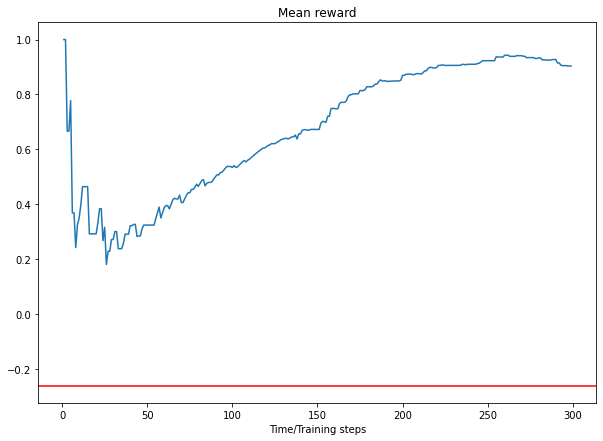

In [84]:
# Import a Trainable (one of RLlib's built-in algorithms):
# We start our endeavor with the Bandit algorithms here b/c they are specialized in solving
# n-arm/recommendation problems.
from ray.rllib.agents.bandit import BanditLinUCBTrainer

# Environment wrapping tools for:
# a) Converting MultiDiscrete action space (k-slate recommendations) down to Discrete action space (we only have k=1 for now anyways).
# b) Making sure our google RecSim-style environment is understood by RLlib's Bandit Trainers.
from ray.rllib.env.wrappers.recsim import MultiDiscreteToDiscreteActionWrapper, \
    RecSimObservationBanditWrapper

from ray import tune

tune.register_env(
    "recomm-sys-001-for-bandits",
    lambda config: RecSimObservationBanditWrapper(MultiDiscreteToDiscreteActionWrapper(RecommSys001(config))))

config = {
    # Use our tune-registered "RecommSys001" class.
    "env": "recomm-sys-001-for-bandits",
    "env_config": {
        "num_features": 20,  # E

        "num_items_in_db": 100,
        "num_items_to_select_from": 10,  # D
        "slate_size": 1,  # k=1

        "num_users_in_db": 1,
    },
    #"evaluation_duration_unit": "episodes",
    "timesteps_per_iteration": 1,
}

# Create the RLlib Trainer using above config.
bandit_trainer = BanditLinUCBTrainer(config=config)

# Train for n iterations (timesteps) and collect n-arm rewards.
rewards = []
for _ in range(300):
    result = bandit_trainer.train()
    rewards.append(result["episode_reward_mean"])
    print(".", end="")

# Plot per-timestep (episode) rewards.
plt.figure(figsize=(10,7))
plt.plot(rewards)#x=[i for i in range(len(rewards))], y=rewards, xerr=None, yerr=[sem(rewards) for i in range(len(rewards))])
plt.title("Mean reward")
plt.xlabel("Time/Training steps")

# Add mean random baseline reward (red line).
plt.axhline(y=env_mean_random_reward, color="r", linestyle="-")

plt.show()

## Trying Slate-Q on a harder version of the same environment.

So far, we have dumbed down our environment via the following contraints:

1. An episode was always only one timestep long (via the config.user_time_budget setting of the env).
1. Our slate size (k) was 1 (the algo only had to recommend a single item from the list of suggested ones).
1. We were only dealing with a single user (the underlying user vector never changes and is only sampled once upon environment startup).

Let's try relaxing all of these restrictions and see what happens.

2022-02-16 14:19:20,439	WARNING util.py:60 -- Install gputil for GPU system monitoring.


Avg. episode reward=-3.75+/-0.14
............................................................................................................................................................................................................................................................................................................

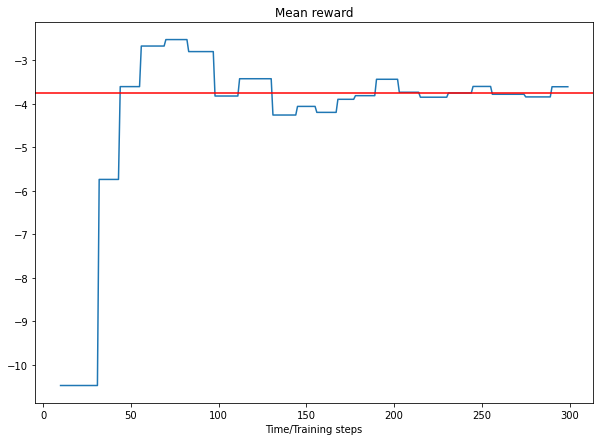

In [ ]:
# Update our env_config: Making things harder.
config.update({
    "env_config": {
        "num_features": 20,  # E (no change)

        "num_items_in_db": 100,  # (no change)
        "num_items_to_select_from": 10,  # D (no change)
        "slate_size": 2,  # k=2

        "num_users_in_db": 100,  # More users!
        "user_time_budget": 10.0,  # Longer episodes.
    },
})

# Re-computing our random baseline.
harder_env = RecommSys001(config=config["env_config"])
harder_env_mean_random_reward, _ = test_env(harder_env)


# Create the RLlib Trainer using above config.
bandit_trainer = BanditLinUCBTrainer(config=config)

# Train for n iterations (timesteps) and collect n-arm rewards.
rewards = []
for _ in range(300):
    result = bandit_trainer.train()
    rewards.append(result["episode_reward_mean"])
    print(".", end="")

# Plot per-timestep (episode) rewards.
plt.figure(figsize=(10,7))
plt.plot(rewards)#x=[i for i in range(len(rewards))], y=rewards, xerr=None, yerr=[sem(rewards) for i in range(len(rewards))])
plt.title("Mean reward")
plt.xlabel("Time/Training steps")

# Add mean random baseline reward (red line).
plt.axhline(y=harder_env_mean_random_reward, color="r", linestyle="-")

plt.show()

#### Well, that doesn't look so well anymore.

Bandits can learn in harder recommender-style envs, but are having a harder time when we increase the number of users, the slate size, or the episode/session length.

Let's try the Slate-Q algorithm, which was designed for k-slate and long-time horizon (user journey) recommendations problems.

### Switching to Slate-Q
<img src="images/slateq.png" width=300>

In [92]:
# Import a Trainable (one of RLlib's built-in algorithms):
# We use the SlateQ algorithm here b/c it is specialized in solving slate recommendation problems
# and works well with RLlib's RecSim environment adapter.

from ray.rllib.agents.slateq import SlateQTrainer

tune.register_env(
    "recomm-sys-001-for-slateq",
    lambda config: RecommSys001(config))

slateq_config = {
    "env": "recomm-sys-001-for-slateq",
    "env_config": {
        "num_features": 20,  # E (no change)

        "num_items_in_db": 100,  # (no change)
        "num_items_to_select_from": 10,  # D (no change)
        "slate_size": 2,  # k=2

        "num_users_in_db": 100,  # More users!
        "user_time_budget": 10.0,  # Longer episodes.
    },
}

# Instantiate the Trainer object using the exact same config as in our last (harder-to-solve env) Bandit experiment above.
slateq_trainer = SlateQTrainer(config=slateq_config)
slateq_trainer

2022-02-16 14:23:03,779	WARNING util.py:60 -- Install gputil for GPU system monitoring.


SlateQTrainer

### Ready to train with RLlib's SlateQ algorithm

That's it, we are ready to train.
Calling `Trainer.train()` will execute a single "training iteration".

One iteration for most algos involves:

1. Sampling from the environment(s)
1. Using the sampled data (observations, actions taken, rewards) to update the policy model (neural network), such that it would pick better actions in the future, leading to higher rewards.

Let's try it out:

In [89]:
results = slateq_trainer.train()

# Delete the config from the results for clarity.
# Only the stats will remain, then.
del results["config"]
# Pretty print the stats.
pprint.pprint(results)

/Users/sven/opt/anaconda3/envs/rllib_tutorials_2/lib/python3.9/site-packages/gym/spaces/box.py:142: UserWarning: WARN: Casting input x to numpy array.
  logger.warn("Casting input x to numpy array.")


{'agent_timesteps_total': 1002,
 'custom_metrics': {},
 'date': '2022-02-16_14-21-44',
 'done': False,
 'episode_len_mean': 14.314285714285715,
 'episode_media': {},
 'episode_reward_max': 4.585414659546117,
 'episode_reward_mean': -2.924722334901943,
 'episode_reward_min': -17.265582475516716,
 'episodes_this_iter': 70,
 'episodes_total': 70,
 'experiment_id': 'd0413ff28fa6462d8a348d1cac1ee193',
 'hist_stats': {'episode_lengths': [13,
                                    15,
                                    14,
                                    15,
                                    15,
                                    17,
                                    12,
                                    15,
                                    16,
                                    16,
                                    14,
                                    15,
                                    13,
                                    15,
                                    14,


Now that we have confirmed we have setup the Trainer correctly, let's call `train()` on it several times (what about 10 times?).

In [90]:
# Run `train()` n times. Repeatedly call `train()` now to see rewards increase.
# Move on once you see episode rewards of 1050.0 or more.
for _ in range(10):
    results = slateq_trainer.train()
    print(f"Iteration={slateq_trainer.iteration}: R(\"return\")={results['episode_reward_mean']}")

Iteration=2: R("return")=-4.073783967522302
Iteration=3: R("return")=-3.3724108400472845
Iteration=4: R("return")=-4.112727510589218
Iteration=5: R("return")=-3.10285891157491
Iteration=6: R("return")=-2.507387553738667
Iteration=7: R("return")=-4.253426039886509
Iteration=8: R("return")=-4.254775122550739
Iteration=9: R("return")=-4.553006182571148
Iteration=10: R("return")=-5.3015834325899505
Iteration=11: R("return")=-5.560551919857484


#### !OPTIONAL HACK!

Feel free to play around with the following code in order to learn how RLlib - under the hood - calculates actions from the environment's observations using the SlateQ Policy and its NN models inside our Trainer object):

In [20]:
# To get the policy inside the Trainer, use `Trainer.get_policy([policy ID]="default_policy")`:
policy = rllib_trainer.get_policy()
print(f"Our Policy right now is: {policy}")

# To get to the model inside any policy, do:
model = policy.model
#print(f"Our Policy's model is: {model}")

# Print out the policy's action and observation spaces.
print(f"Our Policy's observation space is: {policy.observation_space}")
print(f"Our Policy's action space is: {policy.action_space}")

# Produce a random obervation (B=1; batch of size 1).
obs = env.observation_space.sample()
print(torch.stack([torch.from_numpy(v) for k, v in obs["doc"].items()]))

# Get the action logits (as torch tensor).
per_slate_q_values = model.get_per_slate_q_values(user=torch.from_numpy(obs["user"]).unsqueeze(0), doc=torch.stack([torch.from_numpy(v) for k, v in obs["doc"].items()]).unsqueeze(0))
per_slate_q_values = per_slate_q_values.detach().cpu().numpy()
print(f"per_slate_q_values={per_slate_q_values}")


Our Policy right now is: SlateQTorchPolicy
Our Policy's observation space is: Box([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -

In order to release all resources from a Trainer, you can use a Trainer's `stop()` method.
You should definitley run this cell as it frees resources that we'll need later in this tutorial, when we'll do parallel hyperparameter sweeps.

In [23]:
rllib_trainer.stop()

### Moving stuff to the professional level: RLlib in connection w/ Ray Tune

Running any experiments through Ray Tune is the recommended way of doing things with RLlib. If you look at our
<a href="https://github.com/ray-project/ray/tree/master/rllib/examples">examples scripts folder</a>, you will see that almost all of the scripts use Ray Tune to run the particular RLlib workload demonstrated in each script.

<img src="images/rllib_and_tune.png" width=400>

When setting up hyperparameter sweeps for Tune, we'll do this in our already familiar config dict.

So let's take a quick look at our SlateQ algo's default config to understand, which hyperparameters we may want to play around with:

In [24]:
# Configuration dicts and Ray Tune.
# Where are the default configuration dicts stored?

# SlateQ algorithm:
from ray.rllib.agents.slateq import DEFAULT_CONFIG as SLATEQ_DEFAULT_CONFIG
print(f"SlateQ's default config is:")
pprint.pprint(SLATEQ_DEFAULT_CONFIG)

# DQN algorithm:
#from ray.rllib.agents.dqn import DEFAULT_CONFIG as DQN_DEFAULT_CONFIG
#print(f"DQN's default config is:")
#pprint.pprint(DQN_DEFAULT_CONFIG)

# Common (all algorithms).
#from ray.rllib.agents.trainer import COMMON_CONFIG
#print(f"RLlib Trainer's default config is:")
#pprint.pprint(COMMON_CONFIG)

SlateQ's default config is:
{'_disable_action_flattening': False,
 '_disable_execution_plan_api': False,
 '_disable_preprocessor_api': False,
 '_fake_gpus': False,
 '_tf_policy_handles_more_than_one_loss': False,
 'action_space': None,
 'actions_in_input_normalized': False,
 'adam_epsilon': 1e-08,
 'always_attach_evaluation_results': False,
 'batch_mode': 'truncate_episodes',
 'buffer_size': -1,
 'callbacks': <class 'ray.rllib.agents.callbacks.DefaultCallbacks'>,
 'clip_actions': False,
 'clip_rewards': None,
 'collect_metrics_timeout': -1,
 'compress_observations': False,
 'create_env_on_driver': False,
 'custom_eval_function': None,
 'custom_resources_per_worker': {},
 'double_q': True,
 'eager_max_retraces': 20,
 'eager_tracing': False,
 'env': None,
 'env_config': {},
 'env_task_fn': None,
 'evaluation_config': {'explore': False},
 'evaluation_duration': 10,
 'evaluation_duration_unit': 'episodes',
 'evaluation_interval': None,
 'evaluation_num_episodes': -1,
 'evaluation_num_worke

### Let's do a very simple grid-search over two learning rates with tune.run().

In particular, we will try the train_batch_sizes 32 and 64 using `tune.grid_search([...])`
inside our config dict:

In [26]:
# Plugging in Ray Tune.
# Note that this is the recommended way to run any experiments with RLlib.
# Reasons:
# - Tune allows you to do hyperparameter tuning in a user-friendly way
#   and at large scale!
# - Tune automatically allocates needed resources for the different
#   hyperparam trials and experiment runs on a cluster.

from ray import tune

# Running stuff with tune, we can re-use the exact
# same config that we used when working with RLlib directly!
tune_config = config.copy()

# Let's add our first hyperparameter search via our config.
tune_config["train_batch_size"] = tune.grid_search([32, 64])

# We will configure an "output" location here to make sure we record all environment interactions.
# This for the second part of this tutorial, in which we will explore offline RL.
tune_config["output"] = "logdir"

# Now that we will run things "automatically" through tune, we have to
# define one or more stopping criteria.
# Tune will stop the run, once any single one of the criteria is matched (not all of them!).
stop = {
    # Note that the keys used here can be anything present in the above `rllib_trainer.train()` output dict.
    "training_iteration": 10,
    "episode_reward_mean": 9.0,
}

# "SlateQ" is a registered name that points to RLlib's SlateQTrainer.
# See `ray/rllib/agents/registry.py`

# Run a simple experiment until one of the stopping criteria is met.
results = tune.run(
    "SlateQ",
    config=tune_config,
    stop=stop,

    # Note that no trainers will be returned from this call here.
    # Tune will create n Trainers internally, run them in parallel and destroy them at the end.
    # However, you can ...
    checkpoint_at_end=True,  # ... create a checkpoint when done.
    checkpoint_freq=10,  # ... create a checkpoint every 10 training iterations.
)

Trial name,status,loc,train_batch_size
SlateQ_my_env_f8560_00000,PENDING,,32
SlateQ_my_env_f8560_00001,PENDING,,64


(SlateQTrainer pid=72456) 2022-02-13 18:25:51,048	INFO trainer.py:861 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(SlateQTrainer pid=72458) 2022-02-13 18:25:51,048	INFO trainer.py:861 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


Trial name,status,loc,train_batch_size
SlateQ_my_env_f8560_00000,RUNNING,127.0.0.1:72456,32
SlateQ_my_env_f8560_00001,RUNNING,127.0.0.1:72458,64


(SlateQTrainer pid=72456) 2022-02-13 18:25:51,155	WARNING util.py:55 -- Install gputil for GPU system monitoring.
(SlateQTrainer pid=72458) 2022-02-13 18:25:51,154	WARNING util.py:55 -- Install gputil for GPU system monitoring.
(SlateQTrainer pid=72456) /Users/sven/opt/anaconda3/envs/ray/lib/python3.8/site-packages/gym/spaces/box.py:142: UserWarning: WARN: Casting input x to numpy array.
(SlateQTrainer pid=72456)   logger.warn("Casting input x to numpy array.")
(SlateQTrainer pid=72458) /Users/sven/opt/anaconda3/envs/ray/lib/python3.8/site-packages/gym/spaces/box.py:142: UserWarning: WARN: Casting input x to numpy array.
(SlateQTrainer pid=72458)   logger.warn("Casting input x to numpy array.")


Trial name,status,loc,train_batch_size
SlateQ_my_env_f8560_00000,RUNNING,127.0.0.1:72456,32
SlateQ_my_env_f8560_00001,RUNNING,127.0.0.1:72458,64


Result for SlateQ_my_env_f8560_00001:
  agent_timesteps_total: 1000
  custom_metrics: {}
  date: 2022-02-13_18-25-53
  done: true
  episode_len_mean: 87.54545454545455
  episode_media: {}
  episode_reward_max: 12.277315709038163
  episode_reward_mean: 9.182349776607046
  episode_reward_min: 6.221774288301231
  episodes_this_iter: 11
  episodes_total: 11
  experiment_id: 2854ee45d5e04d1692c62dbbf2cd328a
  hostname: Svens-MBP
  info:
    last_target_update_ts: 1000
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          choice_beta: 10.0
          choice_loss: 1.3261504173278809
          choice_model.beta: 10.0
          choice_model.score_no_click: 0.0
          choice_score_no_click: 0.0
          grad_gnorm: 0.10184044390916824
          next_q_minus_q: 0.011721569113433361
          next_q_values: 0.07172474265098572
          q_loss: 0.01740223728120327
          q_model.layers.0.bias: -0.005163680762052536
   

Trial name,status,loc,train_batch_size,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
SlateQ_my_env_f8560_00000,RUNNING,127.0.0.1:72456,32,2,5.84984,2000,8.69381,13.4968,5.9909,87.9091
SlateQ_my_env_f8560_00001,TERMINATED,127.0.0.1:72458,64,1,2.04097,1000,9.18235,12.2773,6.22177,87.5455


Result for SlateQ_my_env_f8560_00000:
  agent_timesteps_total: 3000
  custom_metrics: {}
  date: 2022-02-13_18-26-01
  done: false
  episode_len_mean: 87.8529411764706
  episode_media: {}
  episode_reward_max: 13.496796226342333
  episode_reward_mean: 8.542674939247744
  episode_reward_min: 5.9908987127629265
  episodes_this_iter: 12
  episodes_total: 34
  experiment_id: 7f16debe21064adeb50c9cea5966a4ab
  hostname: Svens-MBP
  info:
    last_target_update_ts: 3000
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          choice_beta: 10.710765838623047
          choice_loss: 2.6868820190429688
          choice_model.beta: 10.710765838623047
          choice_model.score_no_click: -0.7926892638206482
          choice_score_no_click: -0.7926892638206482
          grad_gnorm: 438.3589172363281
          next_q_minus_q: -23.313079833984375
          next_q_values: 9057.2119140625
          q_loss: 521.5323486328125
      

Trial name,status,loc,train_batch_size,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
SlateQ_my_env_f8560_00000,RUNNING,127.0.0.1:72456,32,3,9.7602,3000,8.54267,13.4968,5.9909,87.8529
SlateQ_my_env_f8560_00001,TERMINATED,127.0.0.1:72458,64,1,2.04097,1000,9.18235,12.2773,6.22177,87.5455


Trial name,status,loc,train_batch_size,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
SlateQ_my_env_f8560_00000,RUNNING,127.0.0.1:72456,32,4,14.0904,4000,8.5577,13.4968,5.9909,87.9111
SlateQ_my_env_f8560_00001,TERMINATED,127.0.0.1:72458,64,1,2.04097,1000,9.18235,12.2773,6.22177,87.5455


Result for SlateQ_my_env_f8560_00000:
  agent_timesteps_total: 5000
  custom_metrics: {}
  date: 2022-02-13_18-26-09
  done: false
  episode_len_mean: 88.48214285714286
  episode_media: {}
  episode_reward_max: 13.496796226342333
  episode_reward_mean: 8.480204960215547
  episode_reward_min: 5.9908987127629265
  episodes_this_iter: 11
  episodes_total: 56
  experiment_id: 7f16debe21064adeb50c9cea5966a4ab
  hostname: Svens-MBP
  info:
    last_target_update_ts: 5000
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          choice_beta: 10.850476264953613
          choice_loss: 2.6736936569213867
          choice_model.beta: 10.850476264953613
          choice_model.score_no_click: -1.012082576751709
          choice_score_no_click: -1.012082576751709
          grad_gnorm: 5.253176689147949
          next_q_minus_q: 1.8787908554077148
          next_q_values: 130.59974670410156
          q_loss: 1.602462649345398
     

Trial name,status,loc,train_batch_size,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
SlateQ_my_env_f8560_00000,RUNNING,127.0.0.1:72456,32,6,22.7947,6000,8.51982,14.3484,5.34808,88.0882
SlateQ_my_env_f8560_00001,TERMINATED,127.0.0.1:72458,64,1,2.04097,1000,9.18235,12.2773,6.22177,87.5455


Result for SlateQ_my_env_f8560_00000:
  agent_timesteps_total: 7000
  custom_metrics: {}
  date: 2022-02-13_18-26-18
  done: false
  episode_len_mean: 88.31645569620254
  episode_media: {}
  episode_reward_max: 14.348397316568608
  episode_reward_mean: 8.471780915961952
  episode_reward_min: 5.348079643947841
  episodes_this_iter: 11
  episodes_total: 79
  experiment_id: 7f16debe21064adeb50c9cea5966a4ab
  hostname: Svens-MBP
  info:
    last_target_update_ts: 7000
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          choice_beta: 10.843669891357422
          choice_loss: 2.3360838890075684
          choice_model.beta: 10.843669891357422
          choice_model.score_no_click: -1.0141793489456177
          choice_score_no_click: -1.0141793489456177
          grad_gnorm: 2.5946853160858154
          next_q_minus_q: 0.9468803405761719
          next_q_values: 67.03594207763672
          q_loss: 0.7521615624427795
   

Trial name,status,loc,train_batch_size,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
SlateQ_my_env_f8560_00000,RUNNING,127.0.0.1:72456,32,7,27.2,7000,8.47178,14.3484,5.34808,88.3165
SlateQ_my_env_f8560_00001,TERMINATED,127.0.0.1:72458,64,1,2.04097,1000,9.18235,12.2773,6.22177,87.5455


Trial name,status,loc,train_batch_size,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
SlateQ_my_env_f8560_00000,RUNNING,127.0.0.1:72456,32,8,31.4886,8000,8.53312,14.3484,5.34808,88.5222
SlateQ_my_env_f8560_00001,TERMINATED,127.0.0.1:72458,64,1,2.04097,1000,9.18235,12.2773,6.22177,87.5455


Result for SlateQ_my_env_f8560_00000:
  agent_timesteps_total: 9000
  custom_metrics: {}
  date: 2022-02-13_18-26-27
  done: false
  episode_len_mean: 88.61
  episode_media: {}
  episode_reward_max: 14.348397316568608
  episode_reward_mean: 8.488203978658104
  episode_reward_min: 5.348079643947841
  episodes_this_iter: 11
  episodes_total: 101
  experiment_id: 7f16debe21064adeb50c9cea5966a4ab
  hostname: Svens-MBP
  info:
    last_target_update_ts: 9000
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          choice_beta: 10.835955619812012
          choice_loss: 2.959062337875366
          choice_model.beta: 10.835955619812012
          choice_model.score_no_click: -1.0179862976074219
          choice_score_no_click: -1.0179862976074219
          grad_gnorm: 11.886569023132324
          next_q_minus_q: 1.3588831424713135
          next_q_values: 89.31866455078125
          q_loss: 0.9463427662849426
          q_mod

Trial name,status,loc,train_batch_size,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
SlateQ_my_env_f8560_00000,RUNNING,127.0.0.1:72456,32,9,35.668,9000,8.4882,14.3484,5.34808,88.61
SlateQ_my_env_f8560_00001,TERMINATED,127.0.0.1:72458,64,1,2.04097,1000,9.18235,12.2773,6.22177,87.5455


Result for SlateQ_my_env_f8560_00000:
  agent_timesteps_total: 10000
  custom_metrics: {}
  date: 2022-02-13_18-26-31
  done: true
  episode_len_mean: 88.76
  episode_media: {}
  episode_reward_max: 14.348397316568608
  episode_reward_mean: 8.43597573897418
  episode_reward_min: 5.348079643947841
  episodes_this_iter: 11
  episodes_total: 112
  experiment_id: 7f16debe21064adeb50c9cea5966a4ab
  hostname: Svens-MBP
  info:
    last_target_update_ts: 10000
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          choice_beta: 10.830251693725586
          choice_loss: 2.4941964149475098
          choice_model.beta: 10.830251693725586
          choice_model.score_no_click: -1.0198209285736084
          choice_score_no_click: -1.0198209285736084
          grad_gnorm: 13.080735206604004
          next_q_minus_q: -1.5250234603881836
          next_q_values: 76.68445587158203
          q_loss: 3.1740760803222656
          q_m

Trial name,status,loc,train_batch_size,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
SlateQ_my_env_f8560_00000,TERMINATED,127.0.0.1:72456,32,10,40.1782,10000,8.43598,14.3484,5.34808,88.76
SlateQ_my_env_f8560_00001,TERMINATED,127.0.0.1:72458,64,1,2.04097,1000,9.18235,12.2773,6.22177,87.5455


2022-02-13 18:26:32,759	INFO tune.py:636 -- Total run time: 50.46 seconds (49.70 seconds for the tuning loop).


### Why did we use 2 CPUs in the tune run above (1 CPU per trial)?

PPO - by default - SlateQ uses 0 "rollout" workers (`num_workers=0`), meaning all sampling happens on the "local worker". SlateQ uses a replay buffer, which allows it to .

------------------
## 15 min break :)
------------------


(while the above experiment is running (and hopefully learning))


## Introduction to Offline RL

<img src="images/offline_rl.png" width=800>

In [39]:
# The previous tune.run (the one we did before the break) produced "historic data" output.
# We will use this output in the following as input to a newly initialized, untrained offline RL algorithm.

# Let's take a look at the generated file(s) first:
output_dir = results.get_best_logdir(metric="episode_reward_mean", mode="max")
print(output_dir)

# Here is what the best log directory contains:
print("The logdir contains the following files:")
os.listdir(os.path.dirname(output_dir + "/"))

/Users/sven/ray_results/SlateQ/SlateQ_my_env_f8560_00001_1_train_batch_size=64_2022-02-13_18-25-42
The logdir contains the following files:


['result.json',
 'params.pkl',
 'params.json',
 'output-2022-02-13_18-25-51_worker-0_0.json',
 'checkpoint_000001',
 'events.out.tfevents.1644773142.Svens-MBP',
 'progress.csv']

### Using an (offline) input file with an offline RL algorithm.

We will now pretend that we don't have a simulator for our problem (same recommender system problem as above) available, however, let's assume we possess a lot of pre-recorded, historic data from some legacy (non-RL) system.

Assuming that this legacy system wrote some data into a JSON file (we'll simply use the same JSON file that our SlateQ algo produced above), how can we use this historic data to do RL either way?

In [44]:
# Let's configure a new RLlib Trainer, one that's capable of reading the JSON input described
# above and able to learn from this input.

# For simplicity, we'll start with a behavioral cloning (BC) trainer:
from ray.rllib.agents.marwil import BCTrainer

offline_rl_config = {
    # Specify your offline RL algo's historic (JSON) input:
    "input": output_dir + "/output-2022-02-13_18-25-51_worker-0_0.json",
    # Note: For non-offline RL algos, this is set to "sampler" by default.
    #"input": "sampler",
    "observation_space": env.observation_space,
    "action_space": env.action_space,
}

bc_trainer = BCTrainer(config=offline_rl_config)
bc_trainer

2022-02-13 18:58:50,981	WARNING util.py:55 -- Install gputil for GPU system monitoring.


BCTrainer

In [47]:
# Let's train our new behavioral cloning Trainer for some iterations:
for _ in range(5):
    results = bc_trainer.train()
    print(results["episode_reward_mean"])

nan
nan
nan
nan
nan


In [51]:
# Oh no! What happened?
# We don't have an environment! No way to measure rewards per episode.

# A quick fix would be:
# We cheat! Let's use our environment from above to run some separate evaluation workers on while we train:

offline_rl_config.update({
    # 
    "evaluation_interval": 1,
    "evaluation_parallel_to_training": True,
    "evaluation_num_workers": 1,
    "evaluation_duration": 100,
    "evaluation_duration_unit": "episodes",
    "evaluation_config": {
        "env": "my_env",
        "input": "sampler",
    },
})

In [56]:
bc_trainer = BCTrainer(config=offline_rl_config)
print(bc_trainer.evaluation_workers)
#bc_trainer.evaluate()

# Let's train our new behavioral cloning Trainer for some iterations:
for _ in range(5):
    results = bc_trainer.train()
    print(results["episode_reward_mean"])

2022-02-14 10:17:24,104	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-02-14 10:17:24,208	WARNING util.py:55 -- Install gputil for GPU system monitoring.


2022-02-14 10:17:33,257	WARNING trainer.py:1074 -- Worker crashed during call to `step_attempt()`. To try to continue training without the failed worker, set `ignore_worker_failures=True`.


RayTaskError(ValueError): [36mray::RolloutWorker.sample()[39m (pid=72459, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x7f935eef41c0>)
  File "/Users/sven/opt/anaconda3/envs/ray/lib/python3.8/site-packages/ray/rllib/evaluation/rollout_worker.py", line 789, in sample
    raise ValueError(
ValueError: RolloutWorker has no `input_reader` object! Cannot call `sample()`. You can try setting `create_env_on_driver` to True.

### Saving and restoring a trained Trainer.
Currently, `rllib_trainer` is in an already trained state.
It holds optimized weights in its Q-value/Policy's models that allow it to act
already somewhat smart in our environment when given an observation.

However, if we closed this notebook right now, all the effort would have been for nothing.
Let's therefore save the state of our trainer to disk for later!

In [21]:
# We use the `Trainer.save()` method to create a checkpoint.
checkpoint_file = rllib_trainer.save()
print(f"Trainer (at iteration {rllib_trainer.iteration} was saved in '{checkpoint_file}'!")

# Here is what a checkpoint directory contains:
print("The checkpoint directory contains the following files:")
os.listdir(os.path.dirname(checkpoint_file))

Trainer (at iteration 31 was saved in '/Users/sven/ray_results/SlateQTrainer_my_env_2022-02-13_18-01-519mi4r8x8/checkpoint_000031/checkpoint-31'!
The checkpoint directory contains the following files:


['checkpoint-31.tune_metadata', '.is_checkpoint', 'checkpoint-31']

### Restoring and evaluating a Trainer
In the following cell, we'll learn how to restore a saved Trainer from a checkpoint file.

We'll also evaluate a completely new Trainer (should act more or less randomly) vs an already trained one (the one we just restored from the created checkpoint file).

In [22]:
# Pretend, we wanted to pick up training from a previous run:
new_trainer = SlateQTrainer(config=config)
# Evaluate the new trainer (this should yield random results).
results = new_trainer.evaluate()
print(f"Evaluating new trainer: R={results['evaluation']['episode_reward_mean']}")

# Restoring the trained state into the `new_trainer` object.
print(f"Before restoring: Trainer is at iteration={new_trainer.iteration}")
new_trainer.restore(checkpoint_file)
print(f"After restoring: Trainer is at iteration={new_trainer.iteration}")

# Evaluate again (this should yield results we saw after having trained our saved agent).
results = new_trainer.evaluate()
print(f"Evaluating restored trainer: R={results['evaluation']['episode_reward_mean']}")

2022-02-13 18:10:11,788	WARNING util.py:55 -- Install gputil for GPU system monitoring.
2022-02-13 18:10:11,935	INFO trainable.py:472 -- Restored on 127.0.0.1 from checkpoint: /Users/sven/ray_results/SlateQTrainer_my_env_2022-02-13_18-01-519mi4r8x8/checkpoint_000031/checkpoint-31
2022-02-13 18:10:11,936	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 31, '_timesteps_total': 992, '_time_total': 112.33620977401733, '_episodes_total': 347}


Evaluating new trainer: R=nan
Before restoring: Trainer is at iteration=0
After restoring: Trainer is at iteration=31
Evaluating restored trainer: R=nan


## Time for Q&A

...

## Thank you for listening and participating!

### Here are a couple of links that you may find useful.

- The <a href="https://github.com/sven1977/rllib_tutorials/tree/main/rl_conference_2022">github repo of this tutorial</a>.
- <a href="https://docs.ray.io/en/latest/rllib/index.html">RLlib's documentation main page</a>.
- <a href="http://discuss.ray.io">Our discourse forum</a> to ask questions on Ray and its libraries.
- Our <a href="https://forms.gle/9TSdDYUgxYs8SA9e8">Slack channel</a> for interacting with other Ray RLlib users.
- The <a href="https://github.com/ray-project/ray/blob/master/rllib/examples/">RLlib examples scripts folder</a> with tons of examples on how to do different stuff with RLlib.
- A <a href="https://medium.com/distributed-computing-with-ray/reinforcement-learning-with-rllib-in-the-unity-game-engine-1a98080a7c0d">blog post on training with RLlib inside a Unity3D environment</a>.
